## Simulate and Plot Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax

from pfjax.particle_filter import particle_filter as pf
from pfjax import particle_filter_mvn as pfmvn
from pfjax.particle_filter import joint_loglik, particle_loglik, simulate
from pfjax import proj_data
from pfjax.lotvol_model import LotVolModel

In [3]:
key = random.PRNGKey(0)

# parameter values

alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 1
n_obs = 50
lotvol_model = LotVolModel(dt, n_res) 
key, subkey = random.split(key)


x_init = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                     theta=jnp.append(theta[0:6], jnp.array([0., 0.])),
                     key=subkey)

y_meas, x_state = simulate(lotvol_model, n_obs, x_init, theta, subkey)

Plotting the observations of the state (latent variables) as well as the observations. The latent observations are the smooth lines given below and the observations are the slightly more jagged lines.

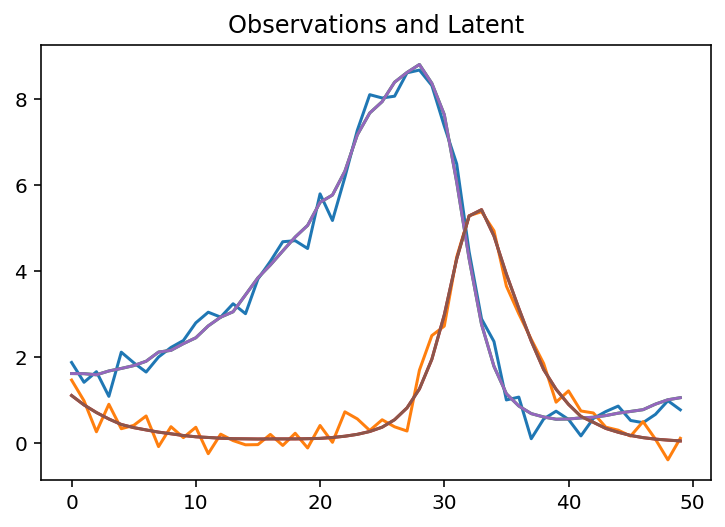

In [4]:
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(jnp.exp(x_state[:,0]))
plt.plot(jnp.exp(x_state[:, 1]))
plt.title("Observations and Latent");

## Parameter Estimation with Complete Data

In other words, we estimate $\theta$ as if both $y_{0:T}$ and $x_{0:T}$ were known.  Let's start with projection plots of the complete data (log)likelihood

$$
\ell(\theta \mid x_{0:T}, y_{0:T}) = \log p(y_0 \mid x_0, \theta) + \sum_{t=1}^T \log p(y_t \mid x_t, \theta) + \log p(x_t \mid x_{t-1}, \theta).
$$

In [21]:
theta_lims = np.array([[0.8, 1.2], [.75, 1.2], [3.5, 4.5], [0.8, 1.2],
                       [.05, .2], [.05, .2], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

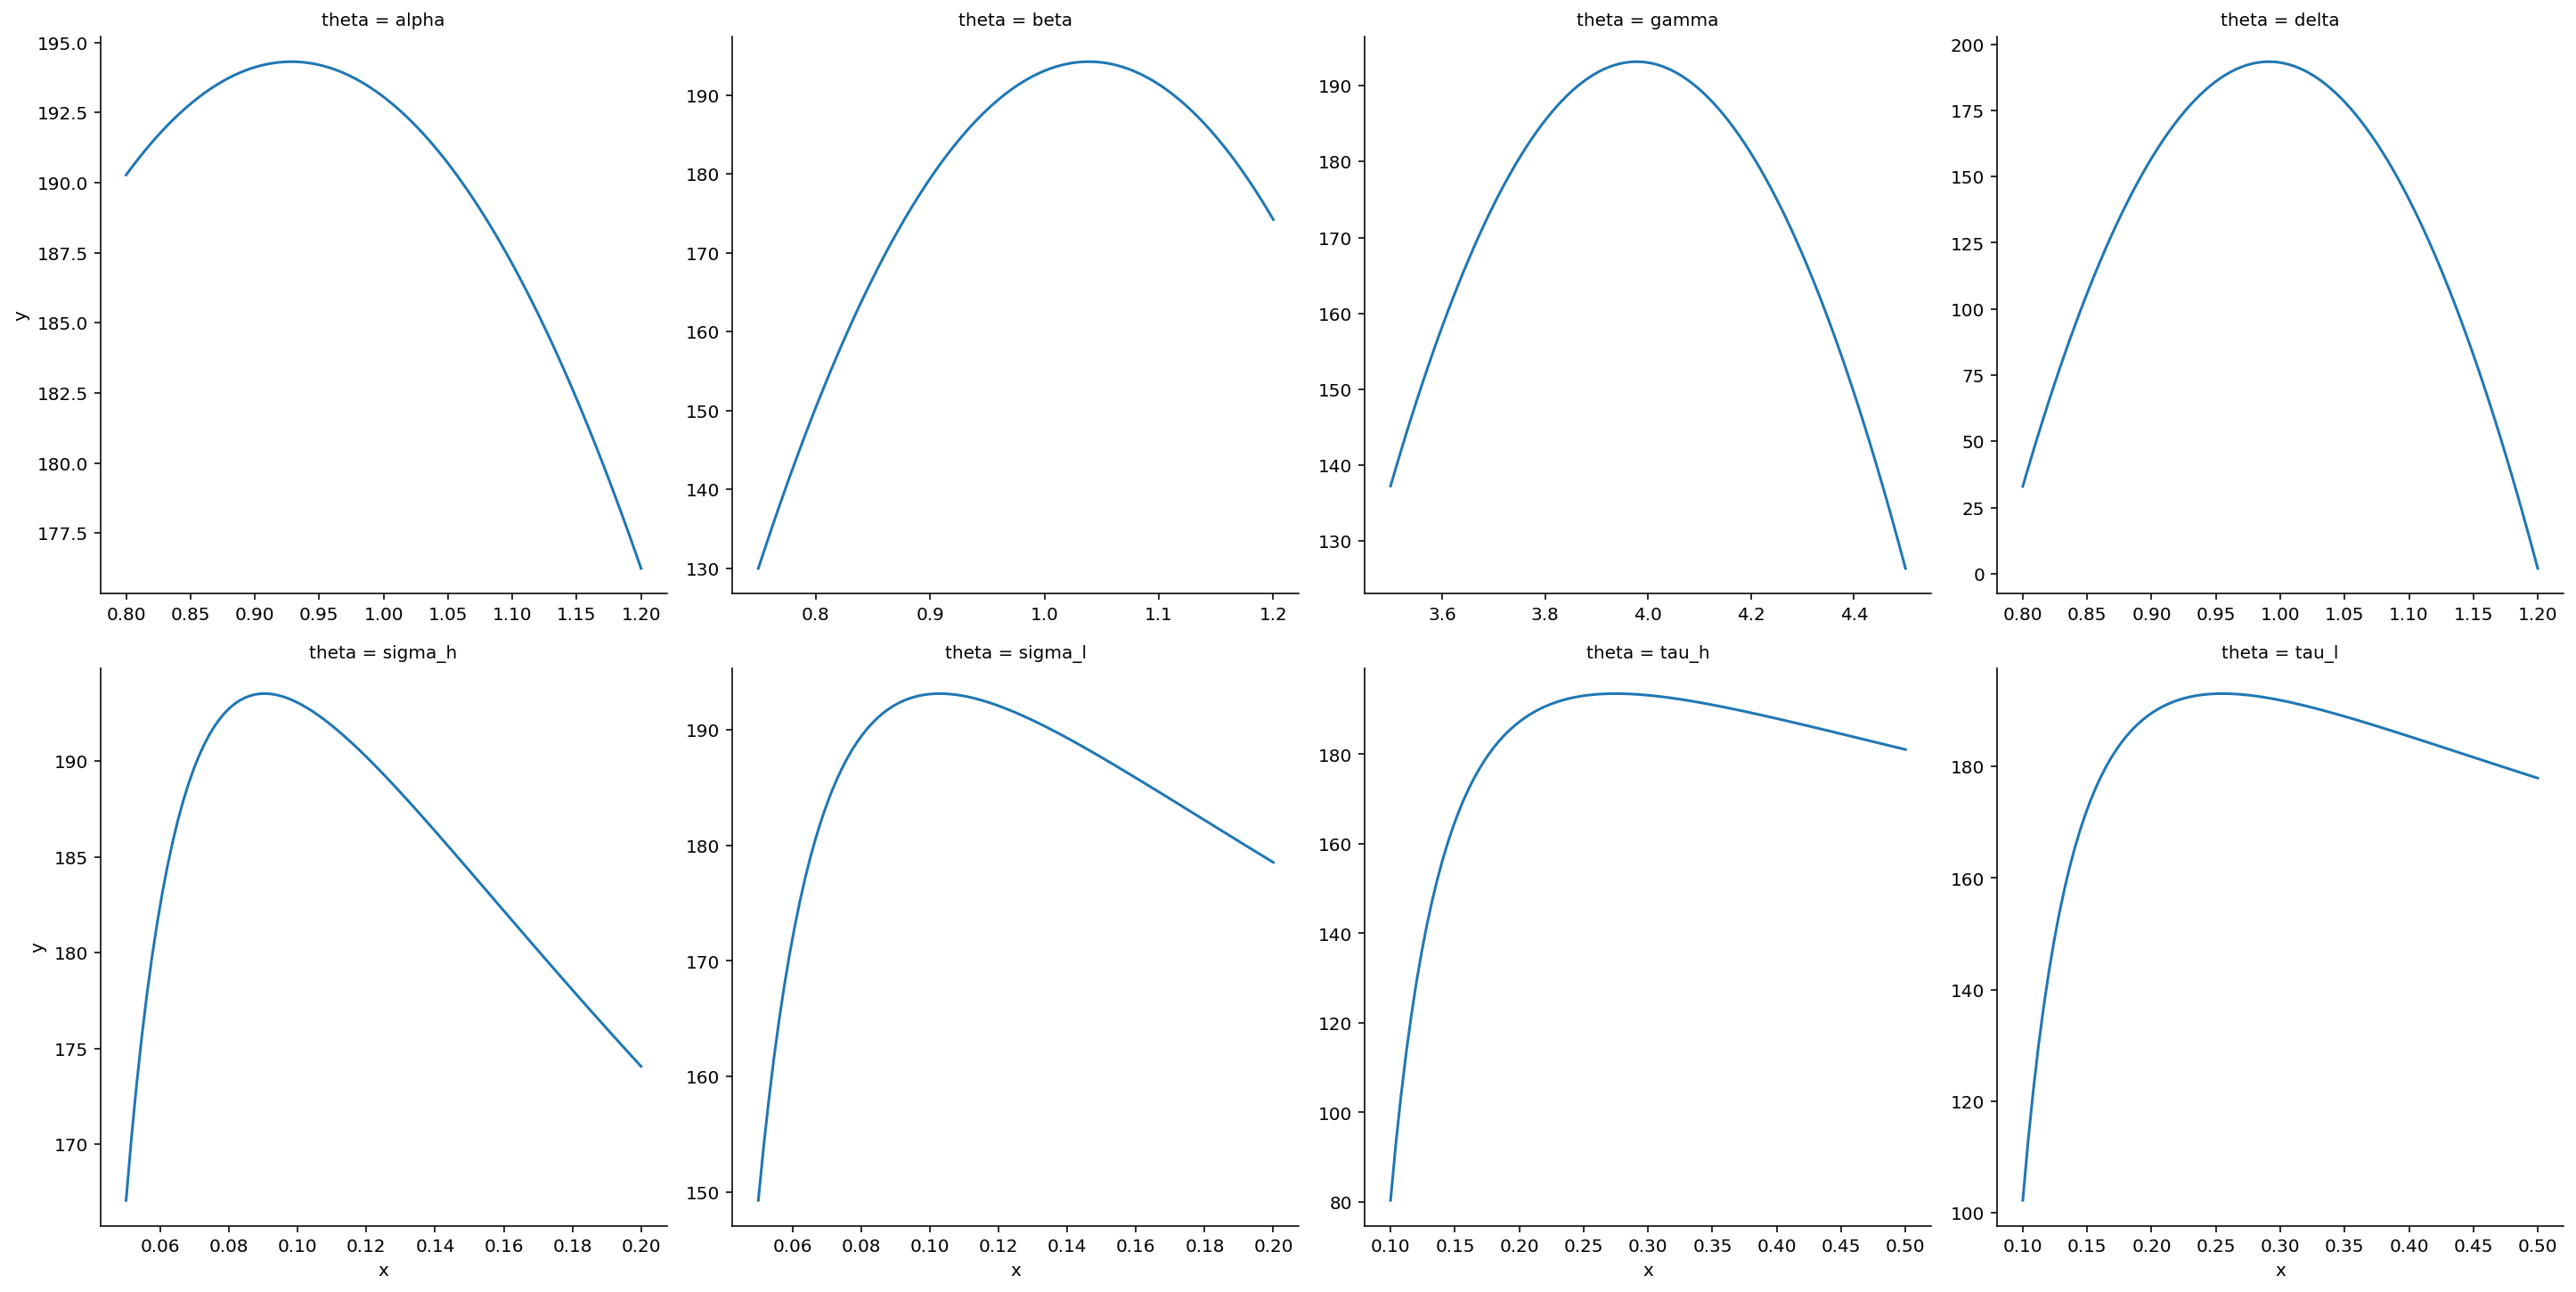

In [22]:
# calculate projection plot
@jax.jit
def lotvol_loglik(theta):
    return joint_loglik(model=lotvol_model, theta=theta, x_state=x_state, y_meas=y_meas)

plot_df = proj_data(lotvol_loglik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
);

## Parameter Estimation with Particle Filter

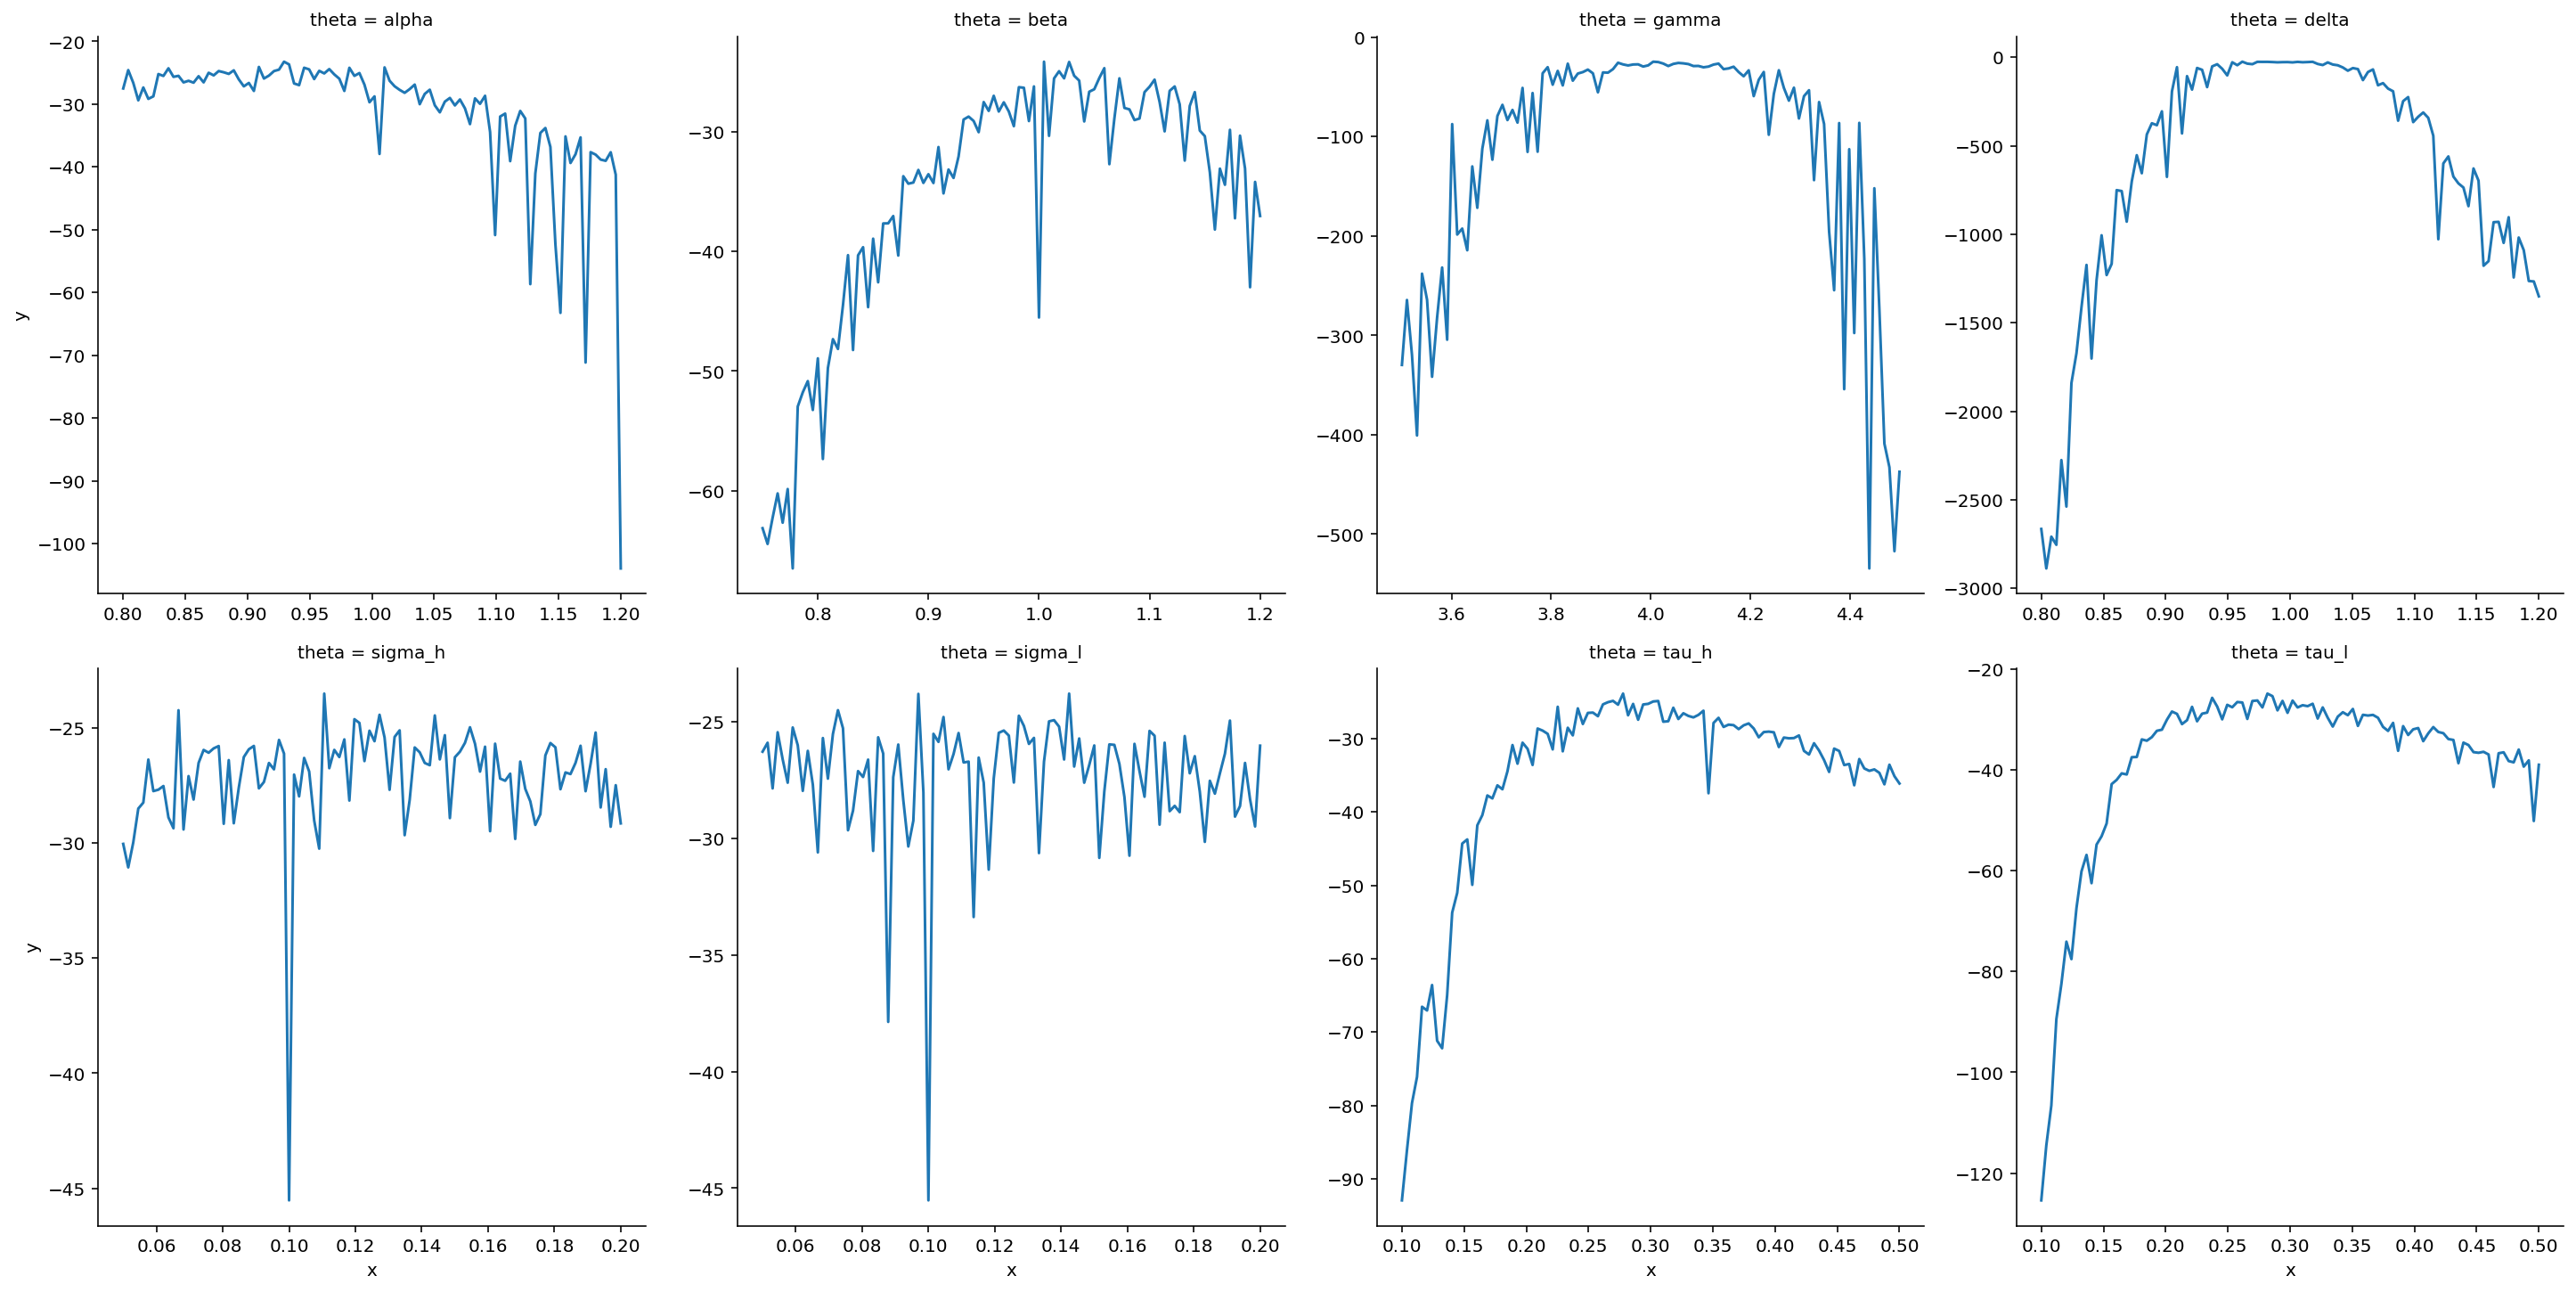

In [23]:
# calculate projection plot
n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = pf(theta=theta, model=lotvol_model, y_meas=y_meas,
                                 n_particles=n_particles, key=key)
    return particle_loglik(temp['logw_particles'])

plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
);

## Parameter Estimation with Particle Filter using MVN Approx.

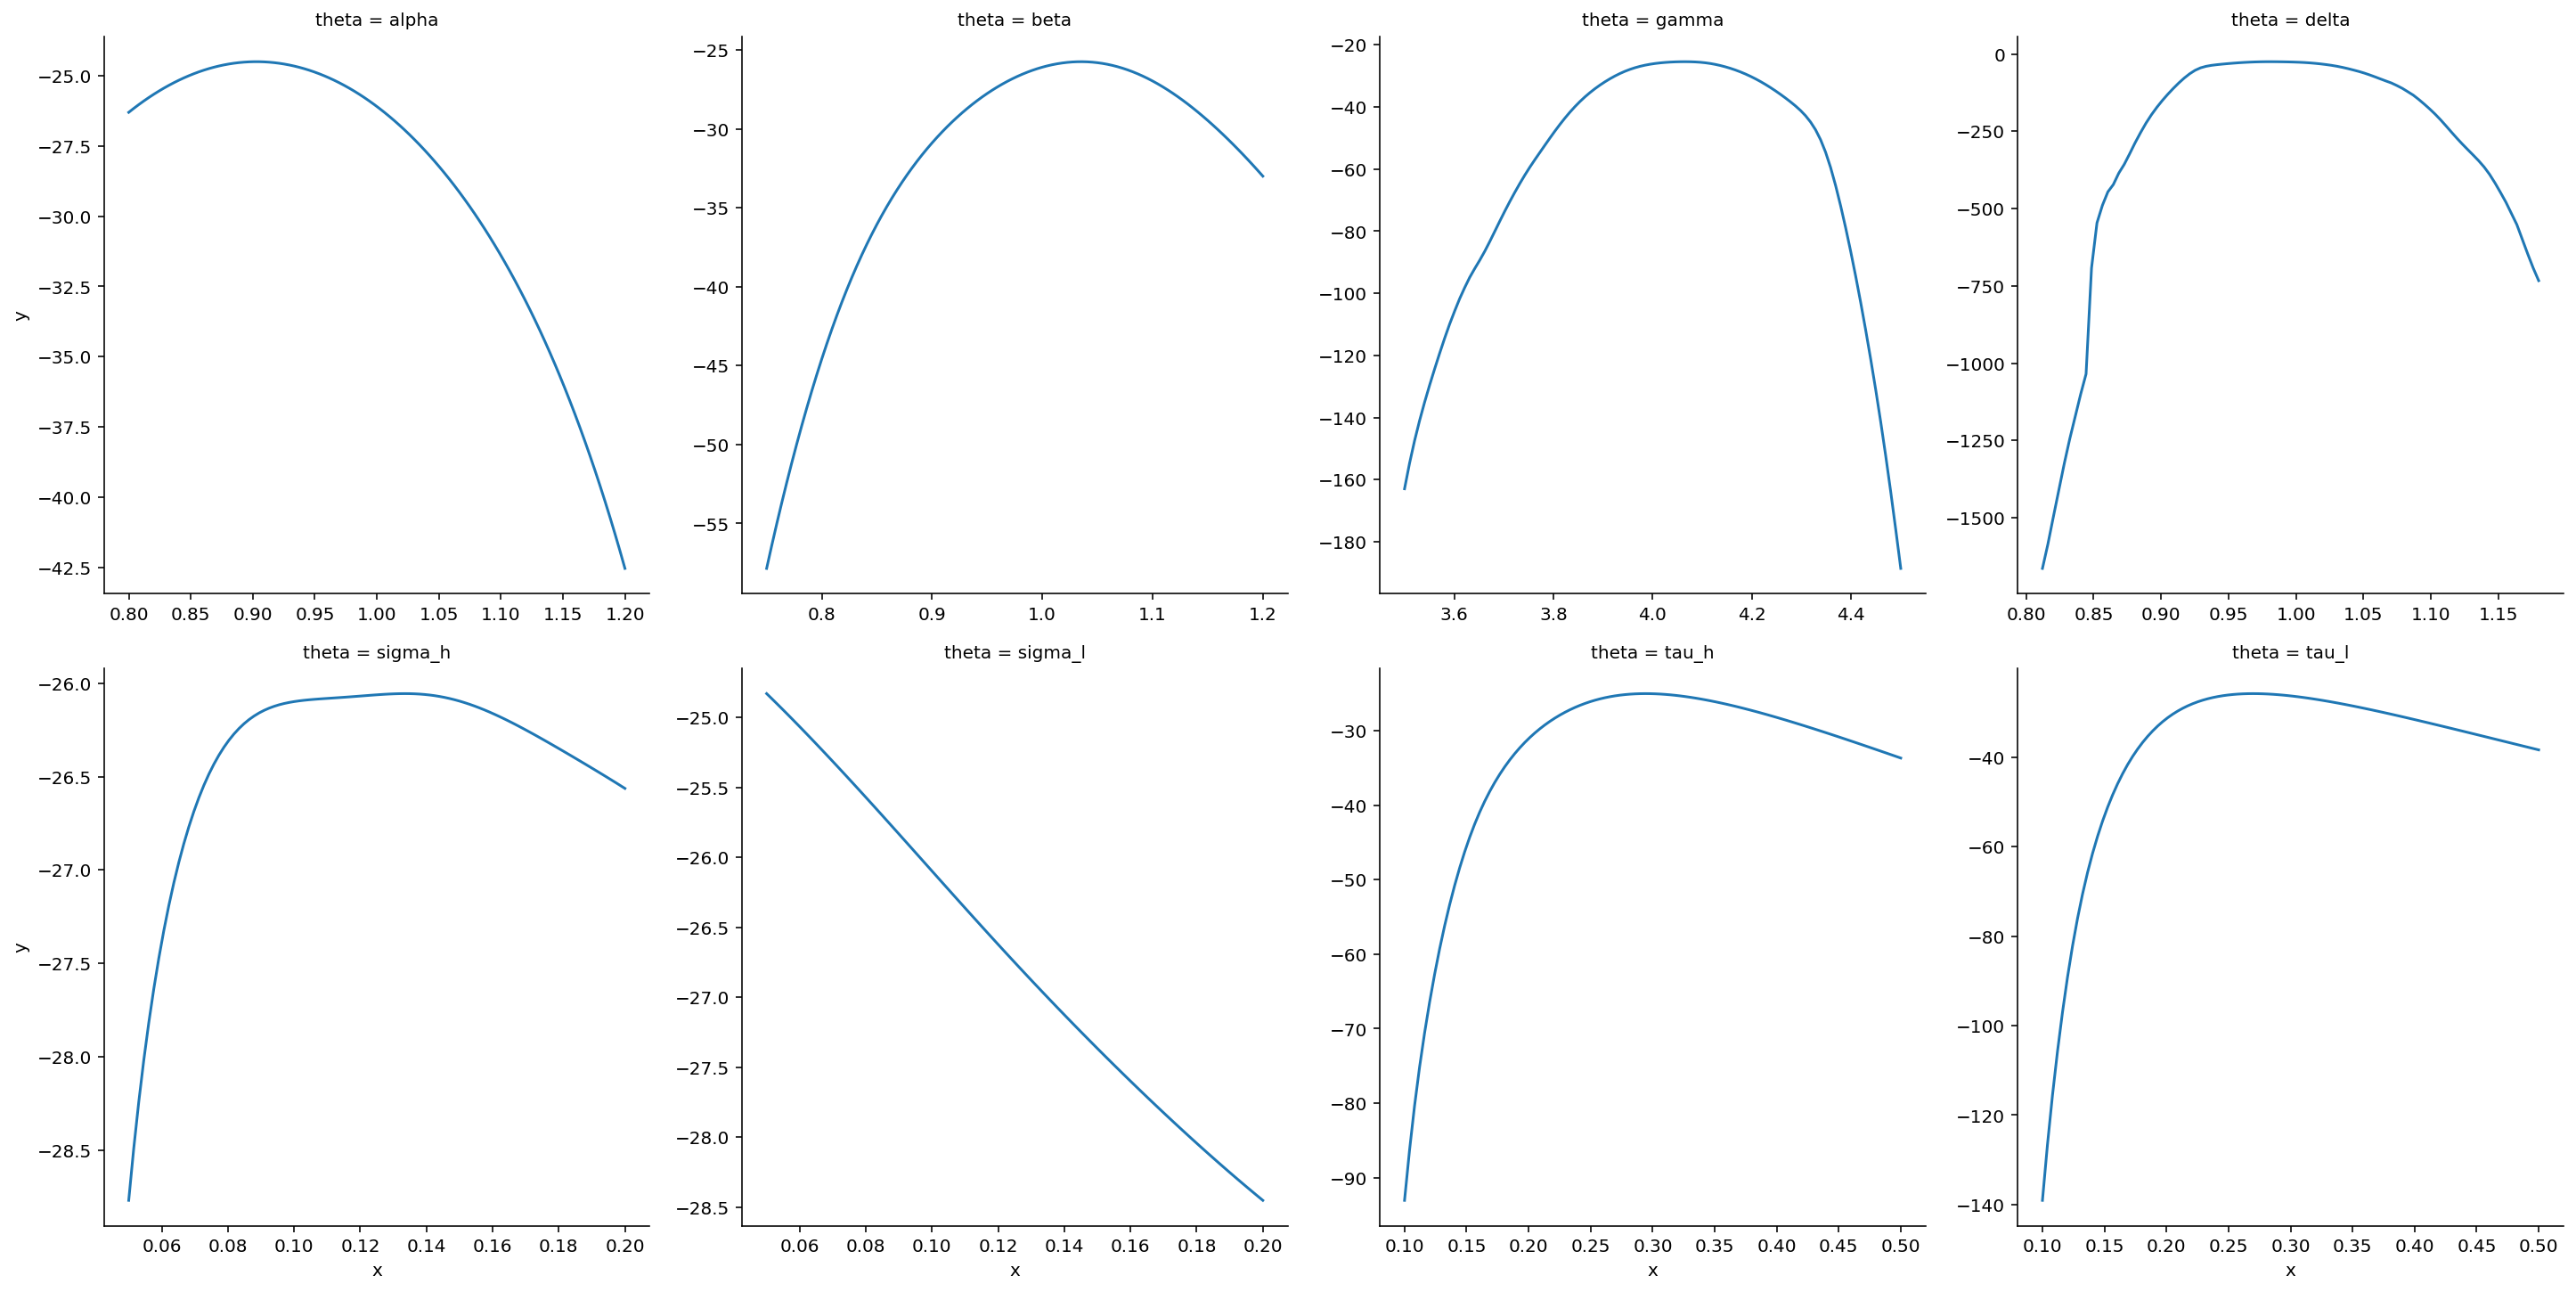

In [24]:
n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = pfmvn.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                                 n_particles=n_particles, key=key)
    return particle_loglik(temp['logw_particles'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

### Stochastic Optimization

For now, we initialize it to be the starting values that were chosen. In addition to this, we also initialize the mask array to be this so that we can verify the results on a one dimensional optimization problem.

### Experimental Notes

- The MVN approximation makes the log-likelihood **much** smoother. This is noticable in the optimization, for example the bootstrap particle filter diverges for `{learning_rate = 1e-4, n_particles=1000}`, but the MVN approximation is able to converge with the same learning rate and half the particles (500). This is with the initial values as the true paramters. 
- 

#### PF MVN

In [10]:
from pfjax.particle_filter import stoch_opt # get_sum_lweights

In [29]:
params, so, grads = stoch_opt(lotvol_model, 
                              params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), 
                            #   params = jnp.array(np.random.random(len(theta))),
                              grad_fun = pfmvn.get_sum_lweights_mvn, 
                              y_meas = y_meas, key=key, 
                              learning_rate=1e-4, 
                              iterations=1000, n_particles=500
                              ,mask=np.array([1,1,1,1,1,1,1,1]))

print("Estimated params: {0}".format(list(round(params, 1))))
print("True params: {0}".format(list(theta)))

Estimated params: [0.90000004, 1.0, 3.6000001, 0.90000004, 0.0, 0.0, 0.3, 0.3]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


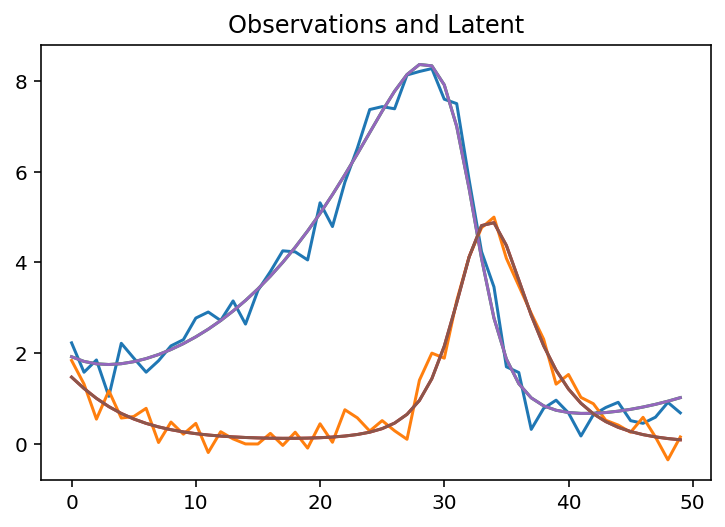

In [34]:
x_init_est = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                  theta=params,
                                  key=subkey)

y_meas_est, x_state_est = simulate(lotvol_model, 
                                   n_obs, 
                                   x_init_est, 
                                   params, 
                                   subkey)

plt.plot(y_meas_est[:, 0], label = "observed y[0]")
plt.plot(y_meas_est[:, 1], label="observed y[1]")
plt.plot(jnp.exp(x_state_est[:, 0]), label="latent x[0]")
plt.plot(jnp.exp(x_state_est[:, 1]), label="latent x[0]")
plt.title("Observations and Latent");

### Pf

In [19]:
from pfjax.particle_filter import get_sum_lweights

In [26]:
pf_params, pf_so, pf_grads = stoch_opt(lotvol_model, 
                              params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), 
#                               params = jnp.array(np.random.random(len(theta))*0.001),
                              grad_fun = get_sum_lweights, 
                              y_meas = y_meas, key=key, 
                              learning_rate=1e-4, 
                              iterations=1000, n_particles=500
                              ,mask=np.array([1,1,1,1,1,1,1,1]))

print("Estimated params: {0}".format(list(round(pf_params, 1))))
print("True params: {0}".format(list(theta)))

Estimated params: [nan, nan, nan, nan, nan, nan, nan, nan]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


## Scratch

In [ ]:
n_particles = 10

pf_out = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)

In [ ]:
i_obs = 1
print(pf_out["X_particles"][i_obs])
print(y_meas[i_obs])

In [ ]:
theta

In [ ]:
@jax.jit
def lotvol_pflik(theta, key):
    temp = pf.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw_particles'])

n_particles = 100

i_theta = 0 # which index of theta to update
theta_min = theta_lims[i_theta][0]
theta_max = theta_lims[i_theta][1]
#theta_min = 3.0
#theta_max = 5.0
theta_seq = np.linspace(theta_min, theta_max, num=n_pts)
ll_seq = np.zeros(theta_seq.shape)
for i in range(n_pts):
    key, subkey = random.split(key)
    theta_tmp = theta
    theta_tmp[i_theta] = theta_seq[i]
    ll_seq[i] = lotvol_pflik(theta_tmp, subkey)
    #theta_tmp = theta_tmp.at[0].set(alpha_seq[i])
    #ll_seq = ll_seq.at[i].set(lotvol_pflik(theta_tmp, subkey))

plt.plot(theta_seq, ll_seq)